# IERG6130 Signal Processing in Wireless Communications and Sensing
## MATLAB Simulation LogBook
| Student Name         | Student ID                |
| :--------------------: | :-------------------------: |
| Han HU  | 1155107763 |

### Raised Cosine Filtering in MATLAB
In this part, we will observe how *Raised Cosine Filtering* will affect the signal.

1. The impulse response

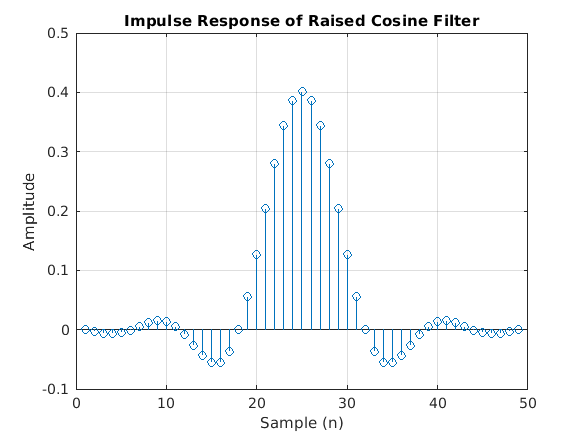

In [6]:
%% parameter settings
Nsym = 6; % FIlter span in symbol duration
beta = 0.5; % Roll-off factor
samplesPerSymbol = 8; % Upsampling factor

%% Define a raised cosine transimitter filter
rcfFilt = comm.RaisedCosineTransmitFilter(...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Visualize a impulse response
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Impulse Response of Raised Cosine Filter');
grid on;



In [7]:
% Normalize to obtain maximum filter tap value of 1
rcfFilt.Gain = 1/max(filterCoeffs.Numerator);


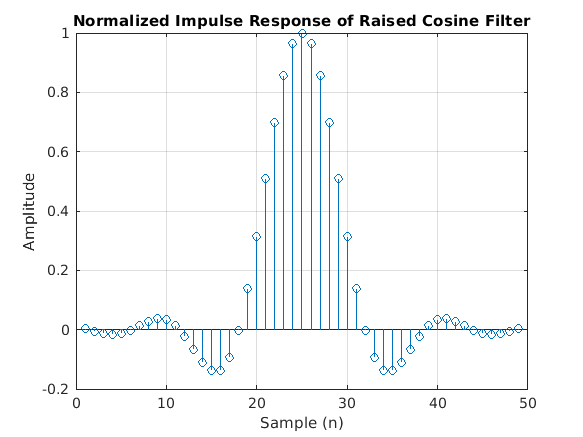

In [8]:
% Visualize the impulse response after normalization
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs_normalized = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs_normalized.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Normalized Impulse Response of Raised Cosine Filter');
grid on;


2. Pulse shaping with raised cosine filter

        A bipolar data sequence is generated.

        No ISI is introduced.   

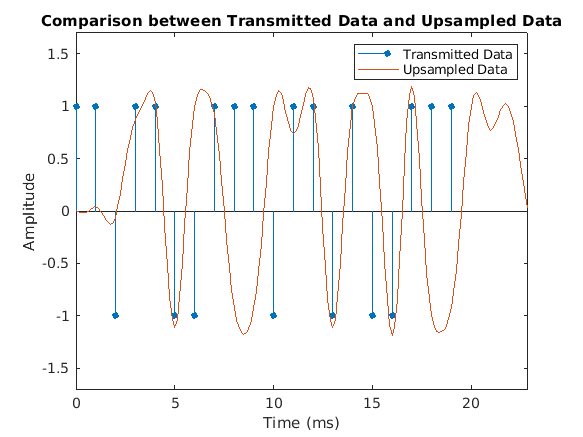

In [10]:
%% Pulse shaping with raised cosine filter
% Bipolar data sequence with no ISI

% Parameters
DataL = 20; % Data length in symbols
R = 1000; % Data rate in symbols per second
Fs = R * samplesPerSymbol; % Sampling frequency in Hz

% Create a local random stream to be used by random number generators for repeatability
hStr = RandStream('mt19937ar','Seed',0);

% Generate random data
data = 2*randi(hStr,[0 1],DataL,1) - 1;
% Time vector sampled at symbol rate in milliseconds
t = (0:DataL-1)/R*1000;

% The plot compares the digital data and the interpolated signal. 
% It is difficult to compare the two signals because the peak response of 
% the filter is delayed by the group delay of the filter (Nsym/(2*R)). 
% Note that we append Nsym/2 zeros at the end of input x to 
% flush all the useful samples out of the filter.

% Filter
yo = rcfFilt([data; zeros(Nsym/2,1)]);
% Time vector sampled at sampling frequency in milliseconds
to = (0:(DataL+Nsym/2)*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig1 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(to,yo,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Comparison between Transmitted Data and Upsampled Data');

3. Compensation for Group Delay

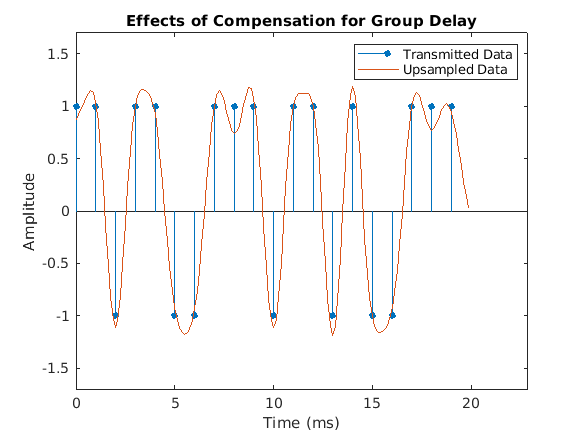

In [11]:
% This step compensates for the raised cosine filter group delay by 
% delaying the input signal. Now it is easy to see how the raised cosine filter 
% upsamples and filters the signal. The filtered signal is identical to 
% the delayed input signal at the input sample times. This shows 
% the raised cosine filter capability to band-limit the signal while avoiding ISI.

% Filter group delay, since raised cosine filter is linear phase and symmetric.
fltDelay = Nsym/(2*R);
% Correct for propagation delay by removing filter transients
y1 = yo(fltDelay*Fs+1:end);
t1 = (0:DataL*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig2 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Effects of Compensation for Group Delay');

4. Different roll factor $\beta$ 

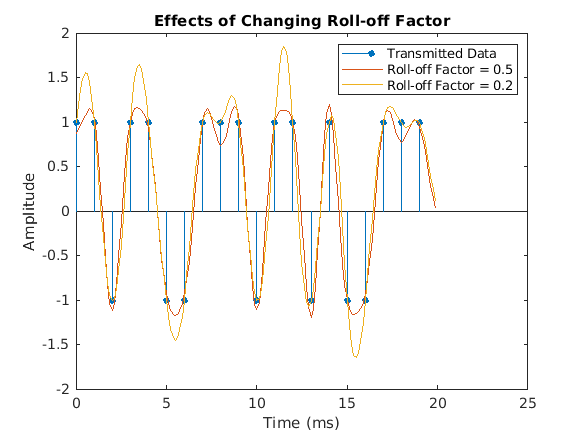

In [15]:
%% Roll-off factor
% This step shows the effect that changing the roll-off factor from .5 (blue curve)
% to .2 (red curve) has on the resulting filtered output. The lower value for 
% roll-off causes the filter to have a narrower transition band 
% causing the filtered signal overshoot to be greater for the red curve 
% than for the blue curve.

% set the roll factor to 0.2
rctFilt2 = comm.RaisedCosineTransmitFilter(...
    'Shape','Normal',...
    'RolloffFactor',0.2,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Normalize to obtain maximum filter tap value of 1
b = coeffs(rctFilt2);
rctFilt2.Gain = 1/max(b.Numerator);
% Filter
y2 = rctFilt2([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y2 = y2(fltDelay*Fs+1:end);
% Plot data
fig3 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% plot filtered data
plot(t1,y1,'LineWidth',1);
plot(t1,y2,'LineWidth',1);
hold off;
% set axes and labels
axis([0 25 -2 2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Roll-off Factor = 0.5','Roll-off Factor = 0.2');
title('Effects of Changing Roll-off Factor');

5. Square-Root Raised Cosine Filters

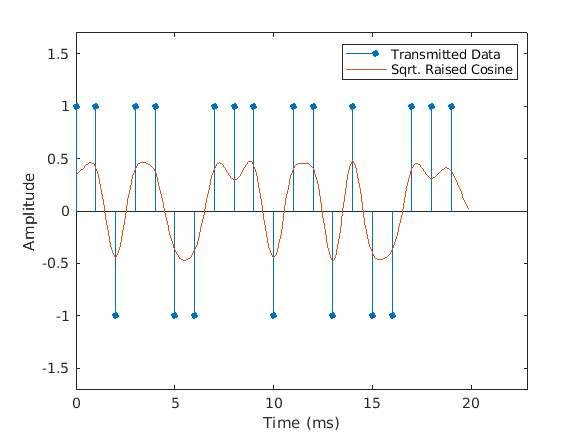

In [29]:
%% Square-Root Raised Cosine Filters
% A typical use of raised cosine filtering is to split the filtering between transmitter and receiver. Both transmitter and receiver employ square-root raised cosine filters. The combination of transmitter and receiver filters is a raised cosine filter, which results in minimum ISI. We specify a square-root raised cosine filter by setting the shape as 'Square root'.

% Design raised cosine filter with given order in symbols
rctFilt3 = comm.RaisedCosineTransmitFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);

% The data stream is upsampled and filtered at the transmitter using the designed filter. This plot shows the transmitted signal when filtered using the square-root raised cosine filter.

% Upsample the filter
y3 = rctFilt3([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y3 = y3(fltDelay*Fs+1:end);
% Plot data
fig4 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,y3,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Sqrt. Raised Cosine');

    The filtered received signal should look like

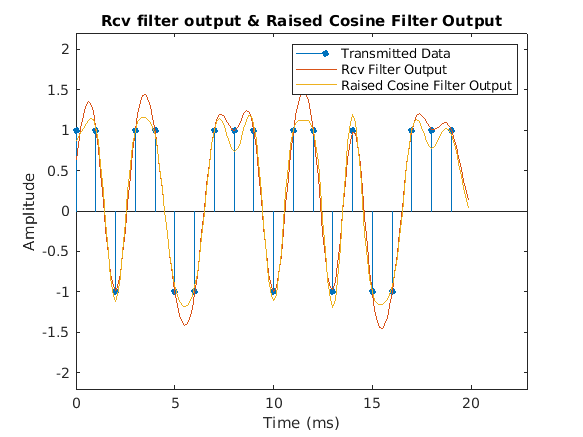

In [26]:
%The transmitted signal (magenta curve) is then filtered at the receiver. We did not decimate the filter output to show the full waveform. The default unit energy normalization ensures that the gain of the combination of the transmit and receive filters is the same as the gain of a normalized raised cosine filter. The filtered received signal, which is virtually identical to the signal filtered using a single raised cosine filter, is depicted by the blue curve at the receiver.

% Design raised cosine filter with given order in symbols
rcrFilt = comm.RaisedCosineReceiveFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'InputSamplesPerSymbol',samplesPerSymbol,...
    'DecimationFactor',1);
% Filter at the receiver
yr = rcrFilt([y3; zeros(Nsym*samplesPerSymbol/2,1)]);
% Correct for propagation delay by removing filter transients
yr = yr(fltDelay*Fs+1:end);
% Plot data
fig5 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,yr,'LineWidth',1);
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -2.2 2.2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Rcv Filter Output', ...
    'Raised Cosine Filter Output');
title('Rcv filter output & Raised Cosine Filter Output');

6. Computational Cost

In [30]:
%% Computational Cost
% In the following table, we compare the computational cost of 
% a polyphase FIR interpolation filter and polyphase FIR decimation filter.
C1 = cost(rctFilt3)
C2 = cost(rcrFilt)

C1 = struct with fields:
   NumCoefficients: 49
                        NumStates: 6
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 41

C2 = struct with fields:
   NumCoefficients: 49
                        NumStates: 48
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 48

### Passband Modulation
In this part, a **Simulink** model is used to observe the basic *Passband Modulation*.

1. The overview of the simulink model
![Passband](resources/PassbandModulationExample_01.png)

In [47]:
%% Passband Modulation
% This model shows a straightforward way to perform passband modulation, by
% multiplying a modulated complex signal with a complex sine wave to
% perform frequency upconversion.  In general, it is preferable to model a
% system at complex baseband.  However, there are some circumstances where
% it is necessary to model the system at real passband. An example of this
% is when an adjacent band signal is processed with a nonlinearity, and
% causes interference in the desired band. This model also illustrates the
% effect of such interference.


%%
clc
clear
close all
% dbstop in PassbandModulationExample at 90
% dbstop in PassbandModulationExample at 104
% 
%%
modelname = '~/IERG6130-simulation/modules/commpassbandmod';
open_system(modelname);
desint   = sprintf([modelname ...
    '/Upconverted\nSpectra/Desired Signal and\nInterference']);
downconv = sprintf([modelname '/Downconverted\nComplex Signal']);
const    = [modelname '/Received Constellation'];

% Set scope visibility
% close_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'off');
% close_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'off');
% close_system(const);
set_param(const, 'openScopeAtSimStart', 'off');
commpassbandmod([], [], [], 'compile');
commpassbandmod([], [], [], 'term');

%% Structure of the Example
%
% The communications link in this model includes these components:
%
% * A |Random Integer Generator| block, used as source of random data
% * A modulator and a pulse shaping filter that perform QPSK modulation and
% root
%   raised cosine pulse shaping.
% * An |Upconverter| block that multiplies the modulated signal by a
% carrier
%   frequency.
% * A source of tone interference.  The interference has a cubic
% nonlinearity
%   which may be toggled on or off.  When the nonlinearity is off, the
%   interference falls completely out of band, but when on, the third
%   harmonic of the tone is introduced into the desired band, causing
%   co-channel interference.
% * An |AWGN Channel| block, set to Eb/No mode.  It specifies two bits per
%   symbol because the modulation format is QPSK.  The signal power is
%   1/(2*8) watts. This is because the original signal power at the
%   modulator is 1 watt. The root-raised cosine filter upsamples the signal
%   by a factor of 8, which reduces the power by that factor.  The
%   frequency upconversion block output takes only the real part of the
%   signal, thereby reducing the power again, this time by a factor of 2.
%   Finally, the symbol period is 1e-6 seconds, to match the original
%   sample time on the |Random Integer Generator| source.
% * A |Downconverter| block that converts the signal from real passband to
%   complex baseband.
% * A root raised cosine pulse shaping filter that decimates back to one
% sample
%   per symbol, and a QPSK demodulator block.
% * BER and RMS EVM metric calculation blocks.

'~' is not a valid model name because it is not a valid MATLAB function name.

So the above code is using Simulink and visualize such results in Jupyter Notebook is not straightforward. In this case, I will try to screenshot the results and include them here.


In [ ]:
%% Results and Displays
% When the simulation runs, two spectrum analyzers and one scatter plot
% open.
%
% The first spectrum analyzer shows the signal and the interference signal
% at passband.  With the nonlinearity turned off, the spectrum of the tone
% interferer falls outside the bandwidth of the desired signal.  With the
% cubic nonlinearity on, the third harmonic of the interference falls into
% the band of the desired signal.

open_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'on');
sim(modelname);
disp('The first spectrum analyzer result')


Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/1-linear-noise-signal.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/1-non-linear-noise-signal.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


In [ ]:
%%
% The second scope illustrates the signal after it has been downconverted
% back to baseband at the receiver, prior to the root raised cosine
% filtering.  Note that with the nonlinearity on, you can see the
% interfering tone present with the baseband signal.

% close_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'off');
open_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'on');
sim(modelname);
disp('The second scope result')

Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/2-sp.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/2-sp-non.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


In [ ]:
%%
% The third scope shows the scatter plot of the received signal, and by
% toggling the nonlinearity on and off, you can view the effect the
% interference has on the scatter plot.  With the nonlinearity on, the
% signal constellation is more diffuse than when the nonlinearity is not
% present.

%%
% close_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'off');
open_system(const);
set_param(const, 'openScopeAtSimStart', 'on');
sim(modelname);
disp('The third scope result')

Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/3-con.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/3-non-con.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


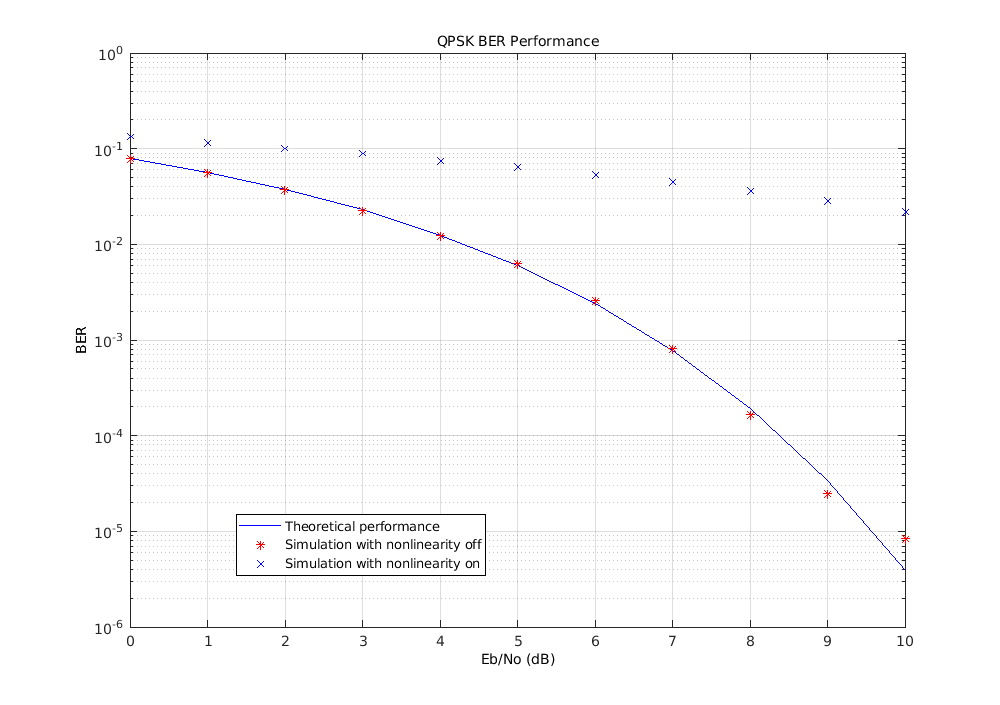

In [46]:
%%
% The model also contains two numerical displays. The first one displays
% the BER of the link. The BER calculation resets each time the
% nonlinearity is toggled on or off.
%
% The second numerical display is the RMS Error Vector Magnitude (EVM)
% measured with the <docid:comm_ref#br3a9d8 EVM Measurement> block.

%% Experimenting with the Example
%
% Double-click on the |Nonlinearity on/off| block to toggle the
% nonlinearity on the interference signal.  Observe the changes this has on
% the received spectrum, constellation, BER and EVM.
%
% By varying the Eb/No parameter, you can produce BER curves, and compare
% the results of the model with theoretical results. Note that the model
% achieves expected theoretical results[ <#10 1> ] for QPSK with the
% nonlinearity off. Furthermore, you can see the effects the nonlinearity
% has on overall BER.
%
% For further experimentation, try changing the value of the Eb/No
% parameter on the AWGN channel block, or changing the power of the
% interference signal. To change the power of the interference signal, open
% the |Interference with Nonlinearity| subsystem, and modify the gain
% value.

hFig = open('~/IERG6130-simulation/results/commpassbandmod_BER.fig');

% exportgraphics(hFig,'results/commpassbandmod_BER.png');

% close(hFig);

% figure;
% imshow('results/commpassbandmod_BER.png');

%% See Also
%
% The |Downconverter| block uses a simple complex multiplication method to
% perform downconversion. You can find an example showing more efficient
% downconversion using IF subsampling at:
% <docid:dsp_ug#example-ifsubsamplingdemo IF Subsampling with Complex
% Multirate Filters>.

In [ ]:
%% Bibliography
% # Proakis, John G., _Digital Communications_, Fourth Ed., sec. 5.2.7, New
% York, McGraw-Hill, 2001.

close_system(modelname, 0);

### Effects of Frequency-Selective Fading

In [24]:
%% FSK Modulation in Flat Fading
% Set modulation order to 4, the modulated symbol rate to 45 bps, and the frequency 
% separation to 200 Hz.

M = 4;                 % Modulation order
symbolRate = 45;       % Symbol rate (bps)
freqSep = 200;         % Frequency separation (Hz)
sampPerSym = ceil(M*freqSep/symbolRate);
fsamp = sampPerSym*symbolRate;
fskMod = comm.FSKModulator(M, ...
    'FrequencySeparation',freqSep, ...
    'SamplesPerSymbol',sampPerSym, ...
    'SymbolRate',symbolRate);
pathDelays = [0 3 10]*1e-6;     % Discrete delays of three-path channel (s)
avgPathGains = [0 -3 -6];       % Average path gains (dB)
channel = comm.RayleighChannel(...
    'SampleRate',fsamp, ...
    'PathDelays',pathDelays, ...
    'AveragePathGains',avgPathGains, ...
    'MaximumDopplerShift',0.01);%, ...
    % 'Visualization','Impulse and frequency responses', ...
    %'SamplesToDisplay','10%');
    

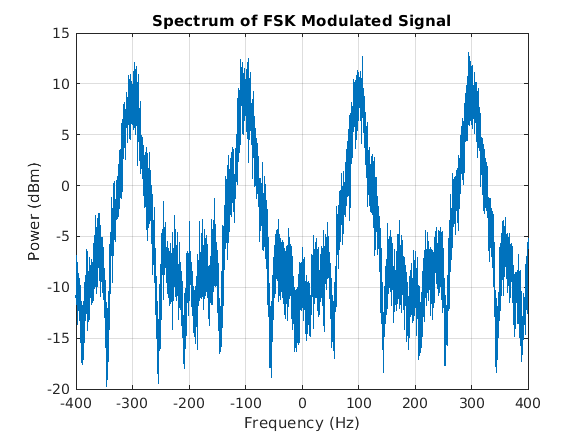

In [25]:
% Generate random data symbols and apply FSK modulation.
%% figures
data = randi([0 3],2000,1);
modSig = fskMod(data);
% spectrum = dsp.SpectrumAnalyzer('SampleRate',fsamp);
% data spectrum before passing through channel
% spectrum(modSig);
% Compute the power spectral density
[pxx, f] = pwelch(modSig, [], [], [], fsamp, 'centered');

% Plot the spectrum data
figure;
plot(f, 10*log10(pxx)+30);
xlabel('Frequency (Hz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum of FSK Modulated Signal');
grid on;

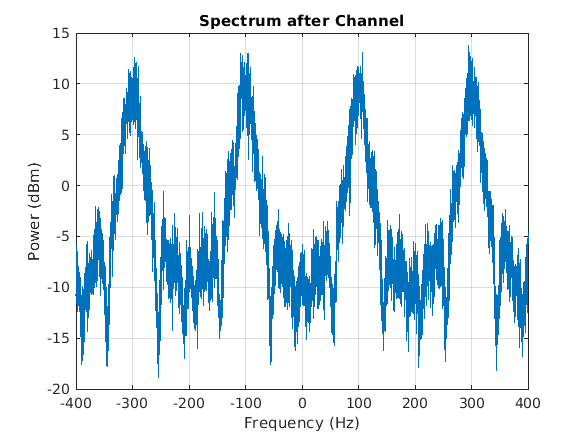

In [26]:
snrdB = 25;
rxSig = awgn(channel(modSig),snrdB);
% spectrum = dsp.SpectrumAnalyzer('SampleRate',fsamp);
% spectrum(rxSig) % data spectrum after passing through channel

% Compute the power spectral density of the received signal
[pxx_rx, f_rx] = pwelch(rxSig, [], [], [], fsamp, 'centered');

% Plot the spectrum data
figure;
plot(f_rx, 10*log10(pxx_rx)+30);
xlabel('Frequency (Hz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum after Channel');
grid on;


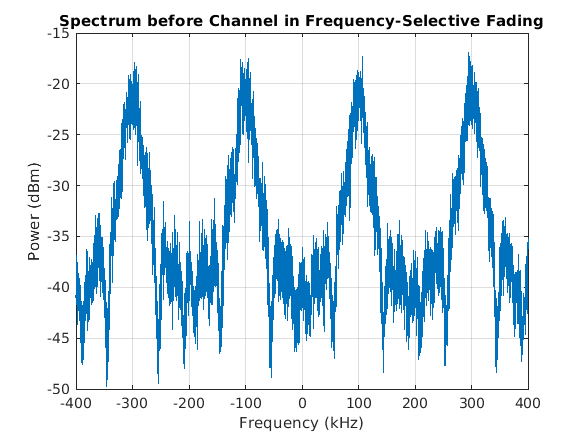

In [27]:
%% FSK Modulation in Frequency-Selective Fading
symbolRate = 45e3;
freqSep = 200e3;
sampPerSym = ceil(M*freqSep/symbolRate);
fsamp = sampPerSym*symbolRate;
release(fskMod)
fskMod.SymbolRate = symbolRate;
fskMod.FrequencySeparation = freqSep;
release(spectrum)
spectrum.SampleRate = sampPerSym*symbolRate;
modSig = fskMod(data);
%spectrum(modSig)
% Compute the power spectral density using pwelch
[pxx, f] = pwelch(modSig, [], [], [], fsamp, 'centered');

% Convert power to dBm
pxx_dBm = 10*log10(pxx) + 30;

% Plot the spectrum data before passing through channel
figure;
plot(f/1000, pxx_dBm);
xlabel('Frequency (kHz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum before Channel in Frequency-Selective Fading');
grid on;




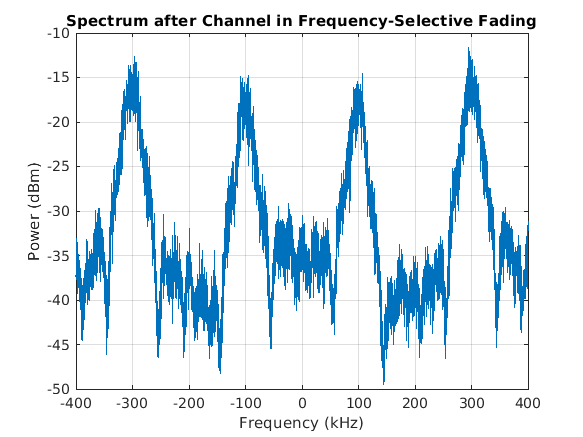

In [28]:
release(channel)
channel.SampleRate = fsamp;
rxSig = awgn(channel(modSig),25);
% spectrum(rxSig) % There are still four identifiable tones but their relative peak power 
% levels differ due to the frequency-selective fading. The signal bandwidth, 800 
% kHz, is larger than the coherence bandwidth, 50 kHz.

% Compute the power spectral density of the received signal using pwelch
[pxx_rx, f_rx] = pwelch(rxSig, [], [], [], fsamp, 'centered');

% Convert received power to dBm
pxx_rx_dBm = 10*log10(pxx_rx) + 30;

% Plot the spectrum data after passing through channel
figure;
plot(f_rx/1000, pxx_rx_dBm);
xlabel('Frequency (kHz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum after Channel in Frequency-Selective Fading');
grid on;

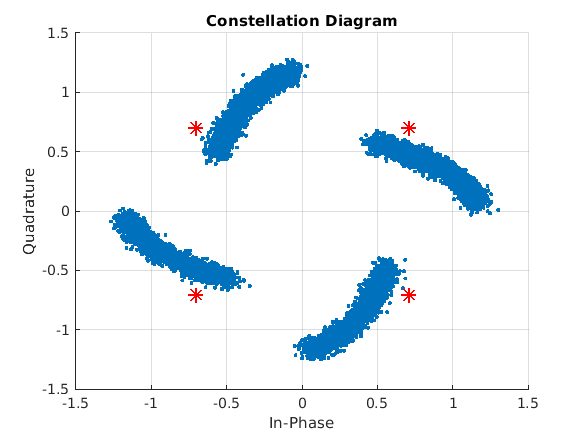

In [29]:
%% QPSK Modulation in Flat Fading


symbolRate = 500;
data = randi([0 3],10000,1);
modSig = pskmod(data,4,pi/4,'gray');
pathDelays = [0 3 10]*1e-6;     % Discrete delays of three-path channel (s)
avgPathGains = [0 -3 -6];       % Average path gains (dB)
fsamp = symbolRate;
channel = comm.RayleighChannel(...
    'SampleRate',fsamp, ...
    'PathDelays',pathDelays, ...
    'AveragePathGains',avgPathGains, ...
    'MaximumDopplerShift',0.01);%, ...
    % 'Visualization','Impulse and frequency responses');
rxSig = awgn(channel(modSig),25);
% Plot the constellation diagram using scatter plot
figure;
% Reference points
ref_points = pskmod(0:3, 4, pi/4, 'gray');

% Constellation diagram
scatter(real(rxSig), imag(rxSig), '.');
hold on;
scatter(real(ref_points), imag(ref_points), 'r*', 'LineWidth', 1.5, 'SizeData', 100);
hold off;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram in flat fading');
grid on;


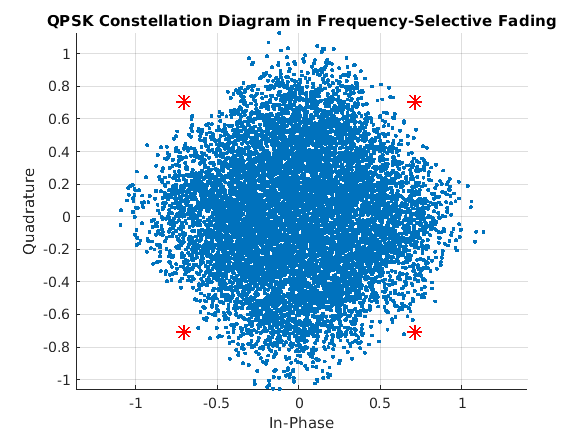

In [30]:
%% QPSK Modulation in Frequency-Selective Fading
symbolRate = 500e3;
release(channel)
channel.SampleRate = symbolRate;
rxSig = awgn(channel(modSig),25);
% constDiagram(rxSig)

% Plot the constellation diagram using scatter plot
figure;

% Reference points
ref_points = pskmod(0:3, 4, pi/4, 'gray');

% Constellation diagram
scatter(real(rxSig), imag(rxSig), '.');
hold on;
scatter(real(ref_points), imag(ref_points), 'r*', 'LineWidth', 1.5, 'SizeData', 100);
hold off;
xlabel('In-Phase');
ylabel('Quadrature');
title('QPSK Constellation Diagram in Frequency-Selective Fading');
grid on;
axis equal;

% As the signal bandwidth is increased from 500 Hz to 500 kHz, the signal 
% becomes highly distorted. This distortion is due to the intersymbol interference 
% (ISI) that comes from time dispersion of the wideband signal. The delay span 
% of the channel (10 microseconds) is now larger than the QPSK symbol period (2 
% microseconds) so the resultant bandlimited impulse response is no longer flat. 
% Alternatively, the signal bandwidth is much larger than the coherence bandwidth, 
% 50 kHz.


As in jupyter notebook, the Channel Visualization tool and Spectrum Analyzer cannot be visualized normally, alternative functions are used here.

For normal MATLAB GUI, these functions should work properly and have better visualization in my current realization even though I use the same Welch method for power density estimation via `pwelch` function.

### WLAN Channel Models

In [24]:
%% WLAN Channel Models
% This example demonstrates passing WLAN S1G, VHT, HT, and non-HT format
% waveforms through appropriate fading channel models. When simulating a
% WLAN communications link, viable options for channel modeling include the
% TGah,TGn and TGac models from WLAN Toolbox&trade; and the additive white
% Gaussian noise (AWGN) and 802.11g models from Communications
% Toolbox&trade;. In this example, it is sufficient to set the channel
% model sampling frequency to match the channel bandwidth because no
% front-end filtering is applied to the signal and the oversampling rate is
% 1.
% 
% In each section of this example, you: 
% 
% * Create a waveform.
% * Transmit it through a fading channel with noise added. 
% * Use a spectrum analyzer to display the waveform before and after it passes 
% through the noisy fading channel. 
%% Pass S1G Waveform Through TGah SISO Channel
% Create a bit stream to use when generating the WLAN S1G format waveform.

bits = randi([0 1],1000,1);
%% 
% Create an S1G configuration object, and then generate a 2 MHz S1G waveform. 
% Calculate the signal power.
%%
s1g = wlanS1GConfig;
preChS1G = wlanWaveformGenerator(bits,s1g);

In [25]:
%% 
% Pass the signal through a TGah SISO channel with AWGN noise (SNR=10 dB)
% and a receiver with a 9 dB noise figure. Recall that the channel model
% sampling frequency is equal to the bandwidth in this example. Set
% property values by using name-value pairs.
% 
% Create a TGah channel object. Set the channel model sampling frequency 
% and channel bandwidth, enable path loss and shadowing, and use the Model-D delay 
% profile.
%%
cbw = s1g.ChannelBandwidth;
fs = 2e6; % Channel model sampling frequency equals the channel bandwidth
tgahChan = wlanTGahChannel('SampleRate',fs,'ChannelBandwidth',cbw, ...
    'LargeScaleFadingEffect','Pathloss and shadowing', ...
    'DelayProfile','Model-D');
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object with SNR = 10 
% dB. Determine the signal power in Watts, accounting for the TGah large scale 
% fading pathloss.
%%
preChSigPwr_dB = 20*log10(mean(abs(preChS1G)));
sigPwr = 10^((preChSigPwr_dB-tgahChan.info.Pathloss)/10);

chNoise = comm.AWGNChannel('NoiseMethod','Signal to noise ratio (SNR)',...
    'SNR',10,'SignalPower', sigPwr);

In [26]:
%% 
% Pass the S1G waveform through a SISO TGah channel and add the AWGN channel 
% noise.
%%
postChS1G = chNoise(tgahChan(preChS1G));

In [27]:
%% 
% Create another AWGNChannel object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [28]:
%% 
% Pass the S1G waveform through the receiver. Choose an appropriate noise 
% variance, nVar, to set the receiver noise level. Here, the receiver noise level 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxS1G = rxNoise(postChS1G,nVar);

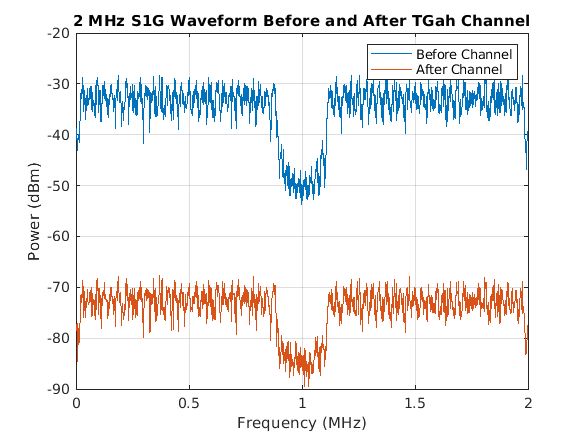

In [29]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '2 MHz S1G Waveform Before and After TGah Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChS1G,rxS1G])
% Calculate power spectrum using pwelch

[preChPxx, f] = pwelch(preChS1G, [], [], [], fs);
[postChPxx, ~] = pwelch(rxS1G, [], [], [], fs);

df = fs / length(preChPxx);  % Frequency resolution

% Convert the PSD (preChPxx and postChPxx) to the power spectrum
preChPowerSpectrum = preChPxx * df;
postChPowerSpectrum = postChPxx * df;

% Plot the power spectrum
figure;
plot(f/1e6, 10*log10(preChPowerSpectrum), f/1e6, 10*log10(postChPowerSpectrum));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
title('2 MHz S1G Waveform Before and After TGah Channel');
legend('Before Channel', 'After Channel');
grid on;


In [30]:
%% 
% Create a VHT configuration object, and generate an 80 MHz VHT waveform. 
% Calculate the signal power.
%%
vht = wlanVHTConfig;
preChVHT = wlanWaveformGenerator(bits,vht);

In [31]:
%% 
% Pass the signal through a TGac SISO channel with AWGN noise (SNR=10 dB) 
% and a receiver with a 9 dB noise figure. Recall that the channel model sampling 
% frequency is equal to the bandwidth in this example. Set parameters using |Name,Value| 
% pairs.
% 
% Create a TGac channel object. Set the channel model sampling frequency 
% and channel bandwidth, enable path loss and shadowing, and use the Model-D delay 
% profile.
%%
cbw = vht.ChannelBandwidth;
fs = 80e6; % Channel model sampling frequency equals the channel bandwidth
tgacChan = wlanTGacChannel('SampleRate',fs,'ChannelBandwidth',cbw, ...
    'LargeScaleFadingEffect','Pathloss and shadowing', ...
    'DelayProfile','Model-D');

In [32]:
%% 
% Create an AWGNChannel object with SNR = 10 
% dB. Determine the signal power in Watts, accounting for the TGac large scale 
% fading pathloss.
%%
preChSigPwr_dB = 20*log10(mean(abs(preChVHT)));
sigPwr = 10^((preChSigPwr_dB-tgacChan.info.Pathloss)/10);

chNoise = comm.AWGNChannel('NoiseMethod','Signal to noise ratio (SNR)',...
    'SNR',10,'SignalPower', sigPwr);

In [33]:
%% 
% Pass the VHT waveform through a SISO TGac channel and add the AWGN channel 
% noise.
%%
postChVHT = chNoise(tgacChan(preChVHT));

In [34]:
%% 
% Create another AWGNChannel object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [35]:
%% 
% Pass the VHT waveform through the receiver. Choose an appropriate noise 
% variance, nVar, to set the receiver noise level. Here, the receiver noise level 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxVHT = rxNoise(postChVHT,nVar);

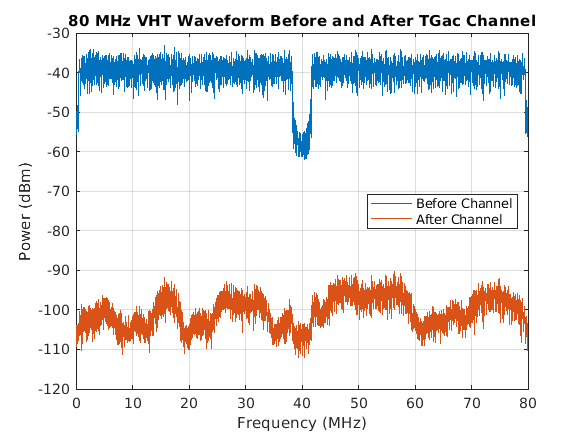

In [36]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '80 MHz VHT Waveform Before and After TGac Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChVHT,rxVHT])
% Calculate power spectrum using pwelch
[preChPxxVHT, fVHT] = pwelch(preChVHT, [], [], [], fs);
[postChPxxVHT, ~] = pwelch(rxVHT, [], [], [], fs);

dfVHT = fs / length(preChPxxVHT);  % Frequency resolution

% Convert the PSD (preChPxxVHT and postChPxxVHT) to the power spectrum
preChPowerSpectrumVHT = preChPxxVHT * dfVHT;
postChPowerSpectrumVHT = postChPxxVHT * dfVHT;

% Plot the power spectrum
figure;
plot(fVHT/1e6, 10*log10(preChPowerSpectrumVHT), fVHT/1e6, 10*log10(postChPowerSpectrumVHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleVHT = '80 MHz VHT Waveform Before and After TGac Channel';
title(plotTitleVHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;


In [37]:
%% 
% Path loss accounts for the roughly 50 to 60 dB of separation between the 
% waveform before and after it passes through the TGac channel. The path loss 
% results from the default transmitter-to-receiver distance of 3 meters, and from 
% shadowing effects. The signal level variation shows the frequency selectivity 
% of the delay profile across the frequency spectrum.
%% Pass HT Waveform Through TGn SISO Channel
% Create a bit stream to use when generating the WLAN HT format waveform.
%%
bits = randi([0 1],1000,1);

In [38]:
%% 
% Create an HT configuration object, and generate an HT waveform.
%%
ht = wlanHTConfig;
preChHT = wlanWaveformGenerator(bits,ht);

In [39]:
%% 
% Pass the signal through a TGn SISO channel with AWGN noise (SNR=10 dB) 
% and a receiver with a 9 dB noise figure. Recall that the channel model sampling 
% frequency is equal to the bandwidth in this example. Set parameters using |Name,Value| 
% pairs.
% 
% Create a TGn channel object. Set the channel model sampling frequency and 
% channel bandwidth, enable path loss and shadowing, and use the Model-F delay 
% profile.
%%
fs = 20e6; % Channel model sampling frequency equals the channel bandwidth
tgnChan = wlanTGnChannel('SampleRate',fs,'LargeScaleFadingEffect', ...
    'Pathloss and shadowing','DelayProfile','Model-F');
%% 

In [40]:
%% 
% Pass the HT waveform through a TGn channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChHT = awgn(tgnChan(preChHT),10,'measured');

In [41]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [42]:
%% 
% Pass the HT waveform through the receiver. Choose an appropriate noise 
% variance, nVar, for setting the receiver noise level. Here, the receiver noise 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxHT = rxNoise(postChHT, nVar);

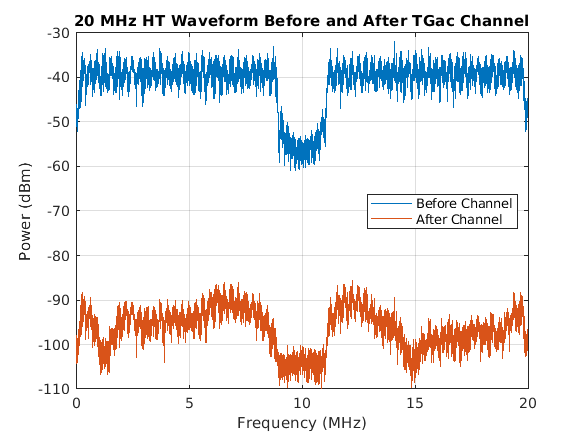

In [45]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '20 MHz HT Waveform Before and After TGn Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChHT,postChHT])
% Calculate power spectrum using pwelch
[preChPxxnHT, fnHT] = pwelch(preChHT, [], [], [], fs);
[postChPxxHT, ~] = pwelch(rxHT, [], [], [], fs);

dfnHT = fs / length(preChPxxnHT);  % Frequency resolution

% Convert the PSD (preChPxxnHT and postChPxxHT) to the power spectrum
preChPowerSpectrumHT = preChPxxnHT * dfnHT;
postChPowerSpectrumHT = postChPxxHT * dfnHT;

% Plot the power spectrum
figure;
plot(fnHT/1e6, 10*log10(preChPowerSpectrumHT), fnHT/1e6, 10*log10(postChPowerSpectrumHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleHT = '20 MHz HT Waveform Before and After TGac Channel';
title(plotTitleHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;

In [46]:
%% 
% Path loss accounts for the roughly 50 to 60 dB of separation between the 
% waveform before and after it passes through the TGn channel. The path loss results 
% from the default transmitter-to-receiver distance of 3 meters, and from shadowing 
% effects. The signal level variation shows the frequency selectivity of the delay 
% profile across the frequency spectrum.
%% Pass Non-HT Waveform Through 802.11g Channel
% Create a bit stream to use when generating the WLAN Non-HT format waveform.
%%
bits = randi([0 1],1000,1);
%% 
% Create a non-HT configuration object, and generate a non-HT waveform.
%%
nht = wlanNonHTConfig;
preChNonHT = wlanWaveformGenerator(bits,nht);

In [47]:
%% 
% Calculate free-space path loss for a transmitter-to-receiver separation 
% distance of 3 meters. Create an 802.11g channel object with a 3 Hz maximum Doppler 
% shift and an RMS path delay equal to two times the sample time. Recall that 
% the channel model sampling frequency is equal to the bandwidth in this example. 
% Create an AWGN channel object.
%%
dist = 3;
fc = 2.4e9;
pathLoss = 10^(-log10(4*pi*dist*(fc/3e8)));
fs = 20e6; % Channel model sampling frequency equals the channel bandwidth
maxDoppShift = 3;
trms = 2/fs;
ch802 = comm.RayleighChannel('SampleRate',fs,'MaximumDopplerShift',maxDoppShift,'PathDelays',trms);

In [48]:
%% 
% Pass the non-HT waveform through an 802.11g channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChNonHT = awgn(ch802(preChNonHT),10,'measured');

In [49]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [50]:
%% 
% Pass the non-HT waveform through the receiver. Choose an appropriate noise 
% variance, |nVar|, for setting the receiver noise level. Here, the receiver noise 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxNonHT = rxNoise(postChNonHT, nVar)* pathLoss;

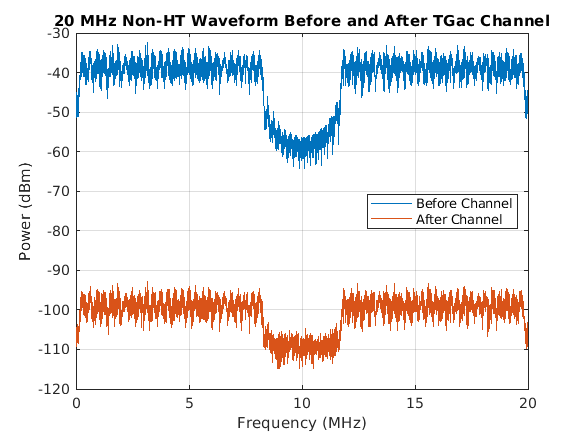

In [51]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '20 MHz Non-HT Waveform Before and After 802.11g Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChNonHT,rxNonHT])
% Calculate power spectrum using pwelch
[preChPxxnHT, fnHT] = pwelch(preChNonHT, [], [], [], fs);
[postChPxxnHT, ~] = pwelch(rxNonHT, [], [], [], fs);

dfnHT = fs / length(preChPxxnHT);  % Frequency resolution

% Convert the PSD (preChPxxnHT and postChPxxHT) to the power spectrum
preChPowerSpectrumnHT = preChPxxnHT * dfnHT;
postChPowerSpectrumnHT = postChPxxnHT * dfnHT;

% Plot the power spectrum
figure;
plot(fnHT/1e6, 10*log10(preChPowerSpectrumnHT), fnHT/1e6, 10*log10(postChPowerSpectrumnHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitlenHT = '20 MHz Non-HT Waveform Before and After TGac Channel';
title(plotTitlenHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;

In [52]:
%% 
% Free-space path loss accounts for the roughly 50 to 60 dB of separation 
% between the waveform before and after it passes through the 802.11g channel. 
% The path loss results from the specified transmitter-to-receiver distance of 
% 3 meters, and from shadowing effects. The signal level variation shows the frequency 
% selectivity of the delay profile across the frequency spectrum.
%% Pass VHT Waveform Through TGac MIMO Channel
% Create a bit stream to use when generating the WLAN VHT format waveform.
%%
bits = randi([0 1],1000,1);


In [53]:
%% 
% Create a multi-user VHT configuration object, and generate a VHT waveform. 
% Set the number of transmit antennas to four. Set the number of space-time streams 
% and the number of receive antennas to 3. Because the number of transmit antennas 
% is not equal to the number of space-time streams, the spatial mapping is not 
% direct. Set the spatial mapping to Hadamard.
%%
ntx = 4;
nsts = 3;
nrx = 3;
vht = wlanVHTConfig('NumTransmitAntennas',ntx, ...
    'NumSpaceTimeStreams',nsts,'SpatialMapping','Hadamard');
preChVHT = wlanWaveformGenerator(bits,vht);

In [54]:
%% 
% Create TGac MIMO channel and AWGN channel objects. Recall that the channel 
% model sampling frequency is equal to the bandwidth in this example. Disable 
% large-scale fading effects.
%%
cbw = vht.ChannelBandwidth;
fs = 80e6; % Channel model sampling frequency equals the channel bandwidth
tgacChan = wlanTGacChannel('SampleRate',fs,'ChannelBandwidth',cbw,...
    'NumTransmitAntennas',ntx,'NumReceiveAntennas',nrx);
tgacChan.LargeScaleFadingEffect = 'None';

In [55]:
%% 
% Pass the VHT waveform through a TGac channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChVHT = awgn(tgacChan(preChVHT),10,'measured');

In [56]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [57]:
%% 
% Pass the multi-user VHT waveform through a noisy TGac channel. Choose 
% an appropriate noise variance, nVar, for setting the AWGN level. Here, the AWGN 
% level is based on the noise variance for a receiver with a 9 dB noise figure. 
% |nVar| = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxVHT = rxNoise(postChVHT,nVar);

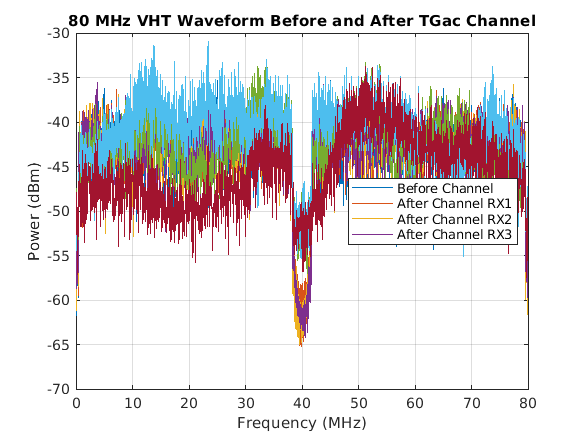

In [59]:
%% 
% Display a spectrum analyzer showing the multiple streams after the channel 
% effects have been added. Use |SpectralAverages| = 10 to reduce noise in the 
% plotted signals.
%%
% title = '80 MHz VHT 4x3 MIMO Waveform After TGac Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'RX1','RX2','RX3'});
% saScope(rxVHT)

% Separate the received signals into individual streams
rxVHT1 = rxVHT(:, 1);
rxVHT2 = rxVHT(:, 2);
rxVHT3 = rxVHT(:, 3);

% Calculate power spectrum using pwelch
[preChPxxVHT, fVHT] = pwelch(preChVHT, [], [], [], fs);
[postChPxxVHT1, ~] = pwelch(rxVHT1, [], [], [], fs);
[postChPxxVHT2, ~] = pwelch(rxVHT2, [], [], [], fs);
[postChPxxVHT3, ~] = pwelch(rxVHT3, [], [], [], fs);

dfVHT = fs / length(preChPxxVHT);  % Frequency resolution

% Convert the PSD (preChPxxVHT and postChPxxVHT) to the power spectrum
preChPowerSpectrumVHT = preChPxxVHT * dfVHT;
postChPowerSpectrumVHT1 = postChPxxVHT1 * dfVHT;
postChPowerSpectrumVHT2 = postChPxxVHT2 * dfVHT;
postChPowerSpectrumVHT3 = postChPxxVHT3 * dfVHT;

% Plot the power spectrum
figure;
plot(fVHT/1e6, 10*log10(postChPowerSpectrumVHT1), ...
     fVHT/1e6, 10*log10(postChPowerSpectrumVHT2), ...
     fVHT/1e6, 10*log10(postChPowerSpectrumVHT3));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleVHT = '80 MHz VHT 4x3 MIMO Waveform After TGac Channel';
title(plotTitleVHT);
legend('After Channel RX1', 'After Channel RX2', 'After Channel RX3', 'Location', 'east');
grid on;

%% 
% The overlaid signals show the TGac channel variation between the received 
% streams.

### WLAN PPDU Structure and Examples